In [1]:
# imports
import os
os.sys.path.append(os.path.abspath(".."))
os.sys.path.append(os.path.abspath("../.."))

import tensorflow as tf

import pandas as pd
import numpy as np
import h5py

from tqdm import tqdm

from matplotlib import pyplot as plt
from plotly import graph_objects as go
import plotly.express as px

from project.notebooks_utils import visuals

import project.download_content as content
from project.utils import data
from project.utils import data_augmentation as da
from project.model.loss import BBOX_REF

from project import train

from copy import deepcopy

import project.download_content as content

from keras.preprocessing import image
from keras.optimizers import Adam, SGD

import pickle

from project.utils.data_bbox_match_hdf5 import load_ohc

datapath = os.path.join(content.DATAPATH, "MODEL", "data_300_vgg.h5")

anchors = BBOX_REF.references.values

tqdm.pandas()

Using TensorFlow backend.


In [2]:
# loading data
images, X = da.load_data('1')

# chosen one image
num = 8121
id, path = images[num]
bboxes_raw = X[num]

def plt_img(img):
    image_bin = image.array_to_img(img)
    plt.figure(figsize=(8, 6))
    plt.imshow(image_bin)
    
def plt_bboxes(img, bboxes):
    image_bin = image.array_to_img(img)
    
    visuals.draw_many_bboxes(image_bin, bboxes[:, -4:], label='original')

    refs = np.array([anchors[i] for i in BBOX_REF.match(bboxes[:, -4:])])
    visuals.draw_many_bboxes(image_bin, refs, label='anchor', color="#ff0000");

## Image without change

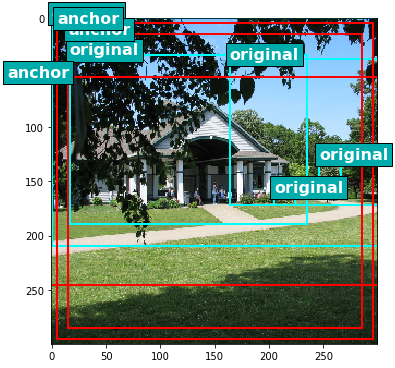

In [3]:
img_bin = image.load_img(path, target_size=(300, 300))
img = image.img_to_array(img_bin)

plt_img(img)
plt_bboxes(img, bboxes_raw)

## flip horizontaly

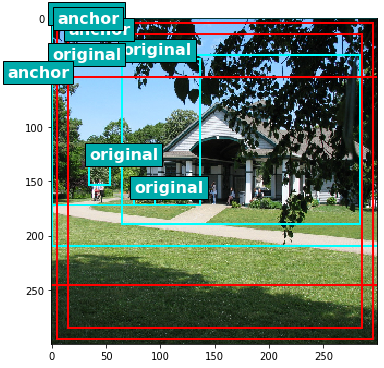

In [4]:
bboxes = deepcopy(bboxes_raw)

img_flip_h = np.flip(img, 1) 
bboxes[:, -4] = 1 - bboxes[:, -4]

plt_img(img_flip_h)
plt_bboxes(img, bboxes)

## flip vertically

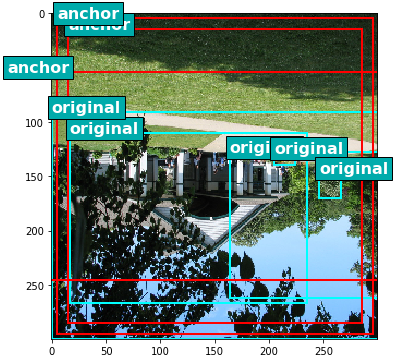

In [5]:
bboxes = deepcopy(bboxes_raw)

img_flip_v = np.flip(img, 0) 
bboxes[:, -3] = 1 - bboxes[:, -3] 

plt_img(img_flip_v)
plt_bboxes(img, bboxes)

## flip horizontaly and vertically

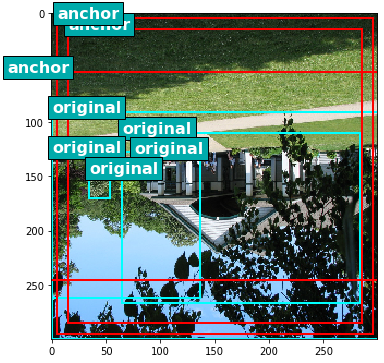

In [6]:
bboxes = deepcopy(bboxes_raw)

img_flip_h_v = np.flip(img, [0, 1])
bboxes[:, -4:-2] = 1 - bboxes[:, -4:-2]

plt_img(img_flip_h_v)
plt_bboxes(img, bboxes)

## zoom 1

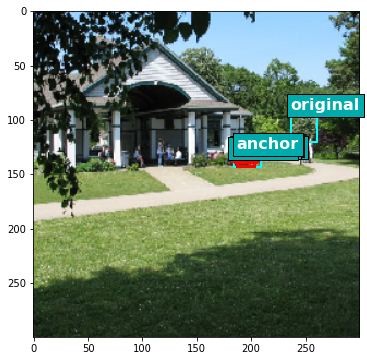

In [7]:
bboxes = deepcopy(bboxes_raw)

img_z, bboxes = da.resize(img, bboxes, .8, .09, .09)

plt_img(np.array(img_z))

plt_bboxes(img_z, bboxes)

## zoom 2

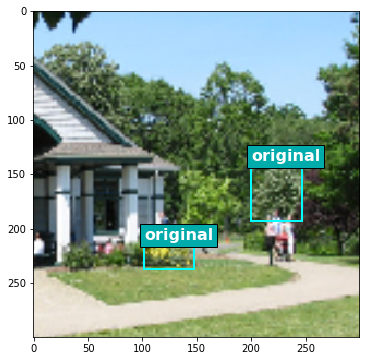

In [8]:
bboxes = deepcopy(bboxes_raw)

img_z, bboxes = da.resize(img, bboxes, .42, -.05, .25)

plt_img(np.array(img_z))

plt_bboxes(img_z, bboxes)

## Original (again)

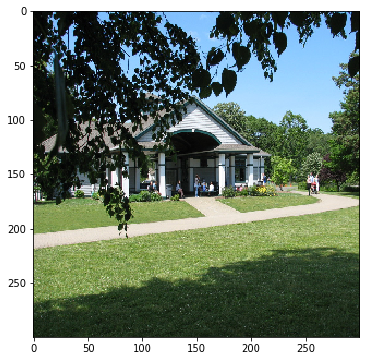

In [9]:
plt_img(img)

## Saturation

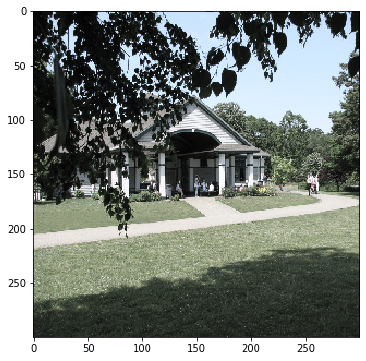

In [10]:
img_bright = tf.image.random_saturation(img, .4, .45).numpy()

plt_img(img_bright)

## Contrast

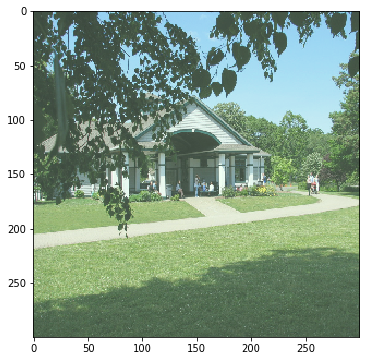

In [11]:
img_bright = tf.image.random_contrast(img, .5, .6).numpy()

plt_img(img_bright)

# Data Augmentationa criteria

In [12]:
classes_count_path = os.path.join(content.DATAPATH, 'METADATA',
                                  'train_classes_count_bboxes.csv')

df_count_train = pd.read_csv(classes_count_path)

display(df_count_train[:30])

LabelSemantic   Type    Count   Leaf     Total  Percentage
0            Clothing  Train  1438128  False  14609671    0.098437
1                 Man  Train  1418594   True  14609671    0.097100
2                Tree  Train  1051342  False  14609671    0.071962
3          Human face  Train  1037710   True  14609671    0.071029
4              Person  Train  1034721  False  14609671    0.070824
5               Woman  Train   767337   True  14609671    0.052523
6            Footwear  Train   744473  False  14609671    0.050958
7              Window  Train   503466   True  14609671    0.034461
8              Flower  Train   345296  False  14609671    0.023635
9               Wheel  Train   340639   True  14609671    0.023316
10              Plant  Train   267852  False  14609671    0.018334
11                Car  Train   248072  False  14609671    0.016980
12         Human hair  Train   234057   True  14609671    0.016021
13          Human arm  Train   208982   True  14609671    0.014304
14         Human head  Train   201633   True  14609671    0.013801
15               Girl  Train   197145   True  14609671    0.013494
16           Building  Train   178632  False  14609671    0.012227
17         Human body  Train   175243   True  14609671    0.011995
18             Mammal  Train   156154  False  14609671    0.010688
19              House  Train   135825   True  14609671    0.009297
20              Chair  Train   132481   True  14609671    0.009068
21               Tire  Train   122615   True  14609671    0.008393
22               Suit  Train   110848   True  14609671    0.007587
23  Fashion accessory  Train    91024  False  14609671    0.006230
24               Food  Train    88422  False  14609671    0.006052
25                Boy  Train    87555   True  14609671    0.005993
26              Table  Train    85691  False  14609671    0.005865
27         Skyscraper  Train    81261   True  14609671    0.005562
28       Land vehicle  Train    81088  False  14609671    0.005550
29               Boat  Train    79113  False  14609671    0.005415

The following graphs explain the rational, but the main concept is based on how unbalanced is the dataset. So, the more irrelevant the category is, the more data augmentation I have to do.

I divided data augmentation in six rules:
 - rule 0: original image only (no augmentation)
 - rule 1: rule 0 + horizontal flip
 - rule 2: rule 1 + saturation
 - rule 3: rule 2 + contrast + horizontal flip with saturation
 - rule 4: rule 3 + zoom 80% (get 80% of the image, lesser the number greater the zoom)
 - rule 5: rule 4 + zoom 60% (get 60% of the image, lesser the number greater the zoom)

In [13]:
df_count_train['DataAug'] = 1

df_count = df_count_train[['LabelSemantic', 'Count', 'DataAug']]
df_count['data'] = 'raw'

df_aug = df_count.copy()
df_aug['data'] = 'augmented'
    
def incremental_rule(x):
    level = 100000/x
    
    if level < 2:
        # 1st rule: original image + horizontal_flip
        return 2
    if level < 4:
        # 2nd rule: 1st rule + saturation
        return 3
    if level < 10:
        # 3rd rule: 2nd rule + contrast + flip_with_saturation
        return 5
    elif level < 30:
        # 4th rule: 3rd rule + zoom_80
        return 10
    else:
        # 5th rule: 4th rule + zoom_60
        return 13

indexes = df_aug[df_aug.Count < 100000].index

df_aug.loc[indexes, 'DataAug'] = df_aug.loc[indexes].Count.apply(incremental_rule)

df_aug.loc[indexes, 'Count'] = df_aug['DataAug'] * df_aug['Count']

fig = go.Figure([go.Scatter(x=df_aug.LabelSemantic.values,
                            y=df_aug.Count.values,
                            marker_color='#d97038',
                            fill='tonexty',
                            name='augmented data'),
                 go.Scatter(x=df_count.LabelSemantic.values,
                            y=df_count.Count.values,
                            marker_color='#005191',
                            fill='tozeroy',
                            name='raw data')])

fig.update_layout(barmode='stack', yaxis_type='log',
                  title_text='Amount of increased data with data augmentation')
fig.show()

# plotting after the 15th category - trying to avoid outliers categories in violin plot
df_all = pd.concat([df_count.iloc[15:], df_aug.iloc[15:]]).reset_index()[['LabelSemantic', 'Count', 'data']]

fig = px.violin(df_all, y="Count", color="data", points='all', color_discrete_sequence=['#005191', '#d97038'])
fig.update_layout(title_text='Data distributions comparison')

fig.show()

#### find category ids in one hot encode model

In [14]:
ohc = load_ohc()

ohc_classes = [c[3:] for c in ohc.get_feature_names()]

def id_in_ohc(x):
    x = x.replace(' ', '_').lower()
    return ohc_classes.index(x)

df_aug['OHC'] = df_aug.LabelSemantic.apply(id_in_ohc)

In [15]:
print(f'Categories to do not augment\n',
      df_aug[df_aug.DataAug == 1].OHC.tolist(), end='\n\n')

print(f'Categories to 1st level augmentation\n',
      df_aug[df_aug.DataAug == 2].OHC.tolist(), end='\n\n')

print(f'Categories to 2nd level augmentation\n',
      df_aug[df_aug.DataAug == 3].OHC.tolist(), end='\n\n')

print(f'Categories to 3rd level augmentation\n',
      df_aug[df_aug.DataAug == 5].OHC.tolist(), end='\n\n')

print(f'Categories to 4th level augmentation\n',
      df_aug[df_aug.DataAug == 10].OHC.tolist(), end='\n\n')

print(f'Categories to 5th level augmentation\n',
      df_aug[df_aug.DataAug == 13].OHC.tolist(), end='\n\n')

Categories to do not augment
 [115, 320, 551, 263, 379, 592, 202, 585, 194, 580, 391, 90, 265, 258, 267, 215, 70, 260, 319, 256, 104, 534, 500]

Categories to 1st level augmentation
 [184, 198, 63, 512, 464, 300, 52, 282, 262, 266, 268, 545, 544, 270, 44, 216, 168, 565]

Categories to 2nd level augmentation
 [49, 482, 495, 269, 362, 54, 515, 170, 57, 42, 211, 466, 440, 192, 159, 153, 329, 209, 279, 229]

Categories to 3rd level augmentation
 [185, 172, 503, 401, 191, 17, 451, 257, 195, 3, 483, 163, 564, 261, 7, 454, 346, 247, 43, 173, 587, 96, 13, 20, 340, 254, 242, 548, 588, 556, 425, 384, 73, 201, 152, 99, 35, 531, 249, 75, 509]

Categories to 4th level augmentation
 [46, 219, 37, 302, 77, 324, 275, 555, 224, 150, 494, 566, 562, 453, 546, 41, 560, 502, 361, 528, 19, 126, 116, 303, 161, 82, 337, 538, 353, 354, 407, 547, 128, 487, 85, 371, 78, 424, 301, 393, 62, 121, 122, 55, 576, 200, 352, 322, 147, 290, 342, 88, 127, 506, 60, 345, 117, 167, 95, 135, 112, 520, 377, 131, 10, 508, 151, 

In [16]:
data_aug_criteria_path = os.path.join(content.DATAPATH,
                                      'data_aug.json')

def aug_level(x):
    if x == 1:
        return 0
    elif x == 2:
        return 1
    elif x == 3:
        return 2
    elif x == 5:
        return 3
    elif x == 10:
        return 4
    elif x == 13:
        return 5
    else:
        raise RuntimeError('Invalid data aug!')
    
df_aug['AugLevel'] = df_aug.DataAug.apply(aug_level)
df_aug['Label'] = df_aug.LabelSemantic.apply(lambda x: x.replace(' ', '_').lower())

(df_aug.set_index('Label')['AugLevel']
       .to_json(data_aug_criteria_path, orient='index'))